In [1]:
from google.colab import files
uploaded = files.upload()

Saving city_day.csv to city_day.csv


# AQI Index Predictor Project

This project predicts the Air Quality Index (AQI) based on various pollutant levels using Machine Learning models. We also include exploratory data analysis and an interactive tool for city-wise AQI trends.

**Author**: Tanush Agrawal  
**Date**: February 2024

In [2]:
# Install necessary package
!pip install ipywidgets --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00


## Step 1: Load and Explore the Dataset

In [3]:
df = pd.read_csv("/content/city_day.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print("Shape of data:", df.shape)
df.head()

Shape of data: (24850, 16)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472,Severe
1,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454,Severe
2,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143,Moderate
3,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319,Very Poor
4,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325,Very Poor


## Step 2: Exploratory Data Analysis (EDA)

### AQI Distribution

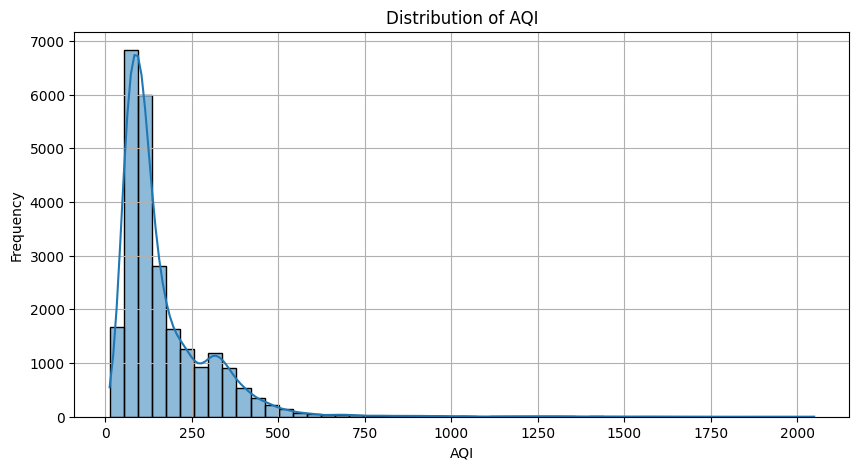

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(df['AQI'], kde=True, bins=50)
plt.title('Distribution of AQI')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### AQI Across Top 10 Cities

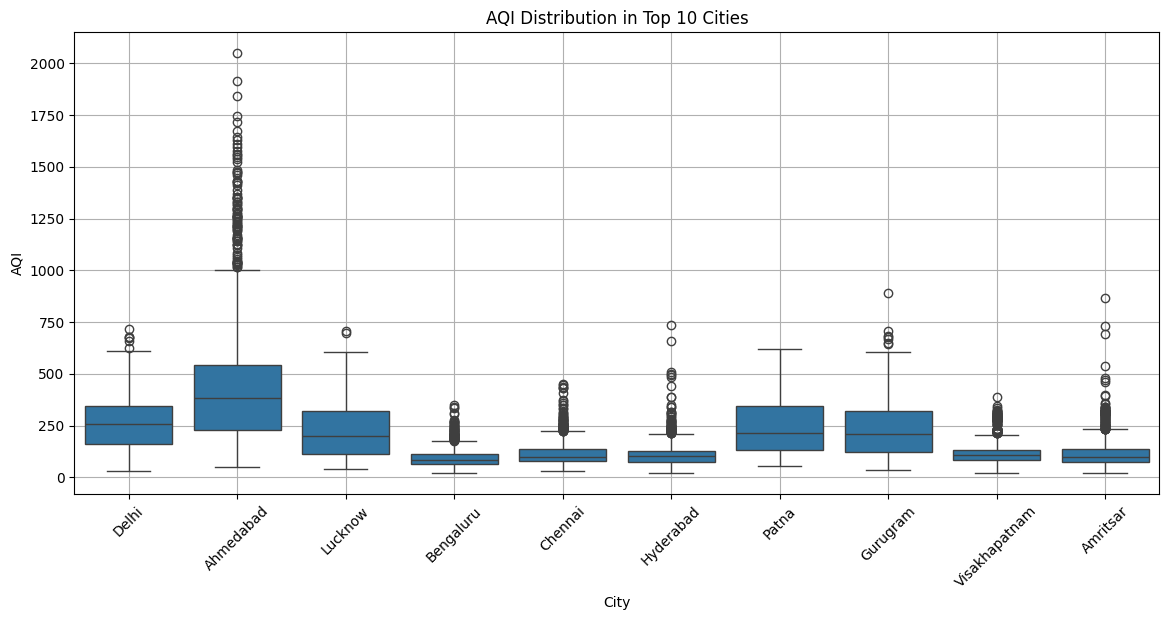

In [5]:
top_cities = df['City'].value_counts().head(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(x='City', y='AQI', data=df[df['City'].isin(top_cities)])
plt.title('AQI Distribution in Top 10 Cities')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Correlation Heatmap

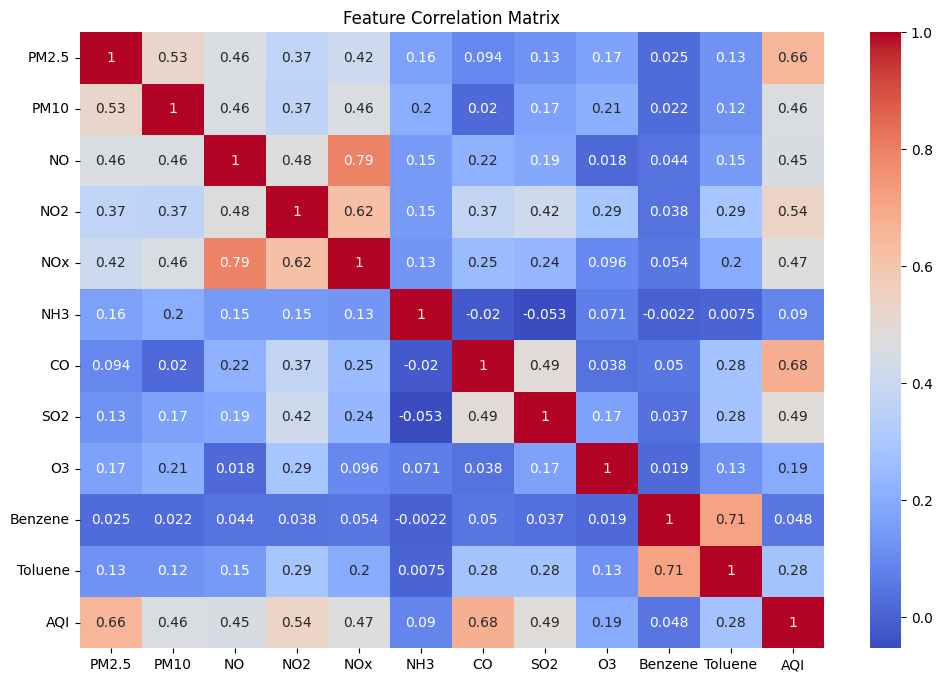

In [6]:
df_corr = df.drop(columns=['City', 'Date', 'AQI_Bucket', 'Xylene'], errors='ignore')
df_corr.fillna(df_corr.median(numeric_only=True), inplace=True)

plt.figure(figsize=(12,8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

## Step 3: Data Cleaning & Feature Engineering

In [7]:
df.drop(columns=['Xylene'], inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)
df_citywise = df.copy()
df_ml = df.drop(columns=['City', 'Date', 'AQI_Bucket'])
X = df_ml.drop('AQI', axis=1)
y = df_ml['AQI']

## Step 4: Model Training and Evaluation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {'R² Score': r2, 'MAE': mae, 'RMSE': rmse}
    trained_models[name] = model

    print(f"\n{name}")
    print("-"*30)
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")


Linear Regression
------------------------------
R² Score: 0.8290
MAE: 30.84
RMSE: 57.95

Decision Tree
------------------------------
R² Score: 0.7906
MAE: 29.77
RMSE: 64.12

Random Forest
------------------------------
R² Score: 0.8746
MAE: 21.59
RMSE: 49.63


### Model Comparison

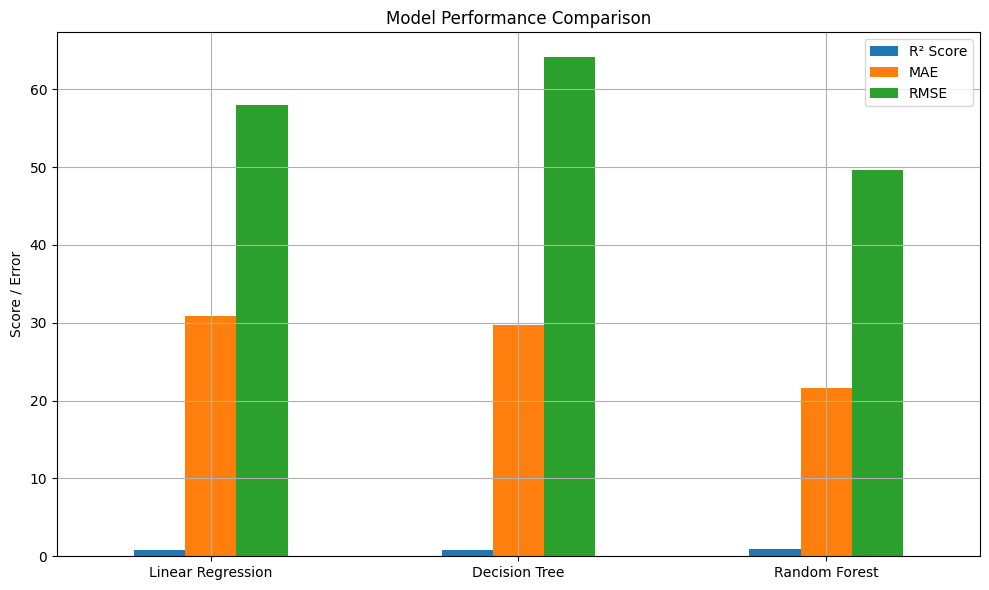

In [9]:
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score / Error")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 5: Feature Importance from Random Forest

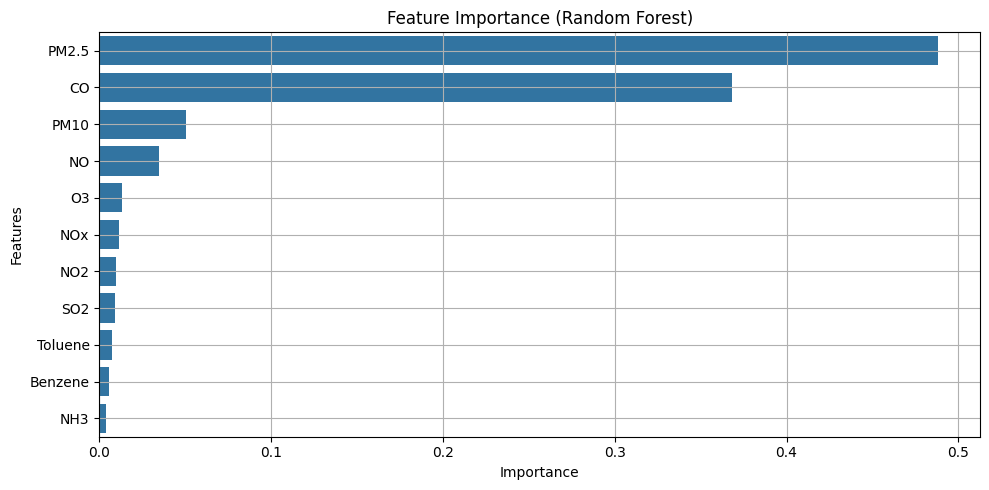

In [10]:
rf_model = trained_models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 6: Interactive City-Wise AQI Trend Visualization

In [11]:
def plot_city_aqi(city):
    city_data = df_citywise[df_citywise['City'] == city].sort_values('Date')
    plt.figure(figsize=(12,5))
    plt.plot(city_data['Date'], city_data['AQI'], marker='o', linestyle='-')
    plt.title(f"AQI Trend in {city}")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.show()

city_dropdown = widgets.Dropdown(
    options=sorted(df_citywise['City'].unique()),
    description='Select City:',
    layout=widgets.Layout(width='50%')
)

widgets.interact(plot_city_aqi, city=city_dropdown);

interactive(children=(Dropdown(description='Select City:', layout=Layout(width='50%'), options=('Ahmedabad', '…